In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import import_ipynb
import regionmask
import geopandas as gpd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import glob
import os

# Import other notebooks
import QIN_tools

importing Jupyter notebook from QIN_tools.ipynb


In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38653 Dashboard: /user/trondkr/proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 63.33 GB


# GLORYS12V1 
This is a notebook for calculating cliamtology from GLORYS12V1 data available from copernicus.eu (https://www.copernicus.eu)

>**The GLORYS12V1 product** is the CMEMS global ocean eddy-resolving (1/12° horizontal resolution and 50 vertical levels) >reanalysis covering the altimetry era 1993-2018. It is based largely on the current real-time global forecasting CMEMS system. The >model component is the NEMO platform driven at the surface by ECMWF ERA-Interim reanalysis. Observations are assimilated by means >of a reduced-order Kalman filter. Along track altimeter data (Sea Level Anomaly), satellite Sea Surface Temperature, Sea Ice >Concentration and in situ temperature and salinity vertical profiles are jointly assimilated. Moreover, a 3D-VAR scheme provides a >correction for the slowly-evolving large-scale biases in temperature and salinity.This product includes daily and monthly mean >files of temperature, salinity, currents, sea level, mixed layer depth and ice parameters from the top to the bottom. The global >ocean output files are displayed on a standard regular grid at 1/12° (approximatively 8 km) and on 50 standard levels.

*The goal of this notebook is to:*
 - Calculate monthly climatology for period 1993-2018
 - Calculate monthly anomalies
 - Calculate seasonal climatology and anomaly
 - Save climatology as netcdf file
 
 We use some functions from here: http://xarray.pydata.org/en/stable/examples/monthly-means.html
 and here:
 http://www.matteodefelice.name/post/aggregating-gridded-data/

In [3]:
%time
# The baseURL for where all monthly data are stored yearly
basepath = "../../oceanography/GLORYS12V1/my.cmems-du.eu/Core/GLOBAL_REANALYSIS_PHY_001_030/global-reanalysis-phy-001-030-monthly"

# Read all of the GLORYS12V1 monthly data into a dataset.
list_of_paths = glob.glob(basepath + "/**/*.nc", recursive=True)
d = xr.open_mfdataset(
    list_of_paths,
    combine="by_coords",
    chunks={"latitude": 250, "longitude": 250, "time": -1},
)
ds = d.assign_coords(longitude=(((d.longitude + 180) % 360) - 180)).sortby("longitude")
print(ds)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 2041, longitude: 4320, time: 312)
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.916664 -79.833336 ... 89.916664 90.0
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83331 179.91669
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2018-12-16T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(1, 250, 250)

In [4]:
month_length = xr.DataArray(
    QIN_tools.get_dpm(ds.time.to_index(), calendar="noleap"),
    coords=[ds.time],
    name="month_length",
)

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = (
    month_length.groupby("time.season")
    / month_length.astype(float).groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby("time.season").sum(dim="time")

In [5]:
print(ds_weighted)
climatology = ds.groupby("time.month").mean("time", keep_attrs=True)
ds_anomaly = ds.groupby("time.month") - climatology

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 2041, longitude: 4320, season: 4)
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.916664 -79.833336 ... 89.916664 90.0
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83331 179.91669
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    mlotst     (season, latitude, longitude) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    zos        (season, latitude, longitude) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    bottomT    (season, latitude, longitude) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    sithick    (season, latitude, longitude) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    siconc     (season, latitude, longitude) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    usi        (season, latitude, longitude) float64 dask.ar

# Mask region


In [6]:
# Load the shapefile
lme_file = "../data/LME/LME66.shp"
lmes = gpd.read_file(lme_file)
print(lmes.head())

   OBJECTID  LME_NUMBER                 LME_NAME  Shape_Leng  Shape_Area  \
0         1        23.0               Baltic Sea  219.326402   61.950021   
1         2        52.0           Sea of Okhotsk  145.932989  213.796584   
2         3        22.0                North Sea  209.486403  103.965247   
3         4         2.0           Gulf of Alaska  468.695688  203.793868   
4         5         9.0  Labrador - Newfoundland  270.847479  114.597691   

                                            geometry  
0  POLYGON ((10.97944 54.38055, 10.98611 54.37805...  
1  POLYGON ((156.70705 51.18858, 156.62592 51.160...  
2  POLYGON ((5.27889 61.98027, 5.24917 61.97388, ...  
3  POLYGON ((-124.59823 47.90313, -125.85582 47.0...  
4  MULTIPOLYGON (((-64.56793 60.45509, -60.09442 ...  


In [7]:
lmes_mask_poly = regionmask.Regions(
    name="lme_mask",
    numbers=list(range(0, 66)),
    names=list(lmes.LME_NAME),
    abbrevs=list(lmes.LME_NAME),
    outlines=list(lmes.geometry.values[i] for i in range(0, 66)),
)

In [8]:
mask = lmes_mask_poly.mask(
    climatology.sel(latitude=slice(0, 90), longitude=slice(-180, -100)),
    lat_name="latitude",
    lon_name="longitude",
)

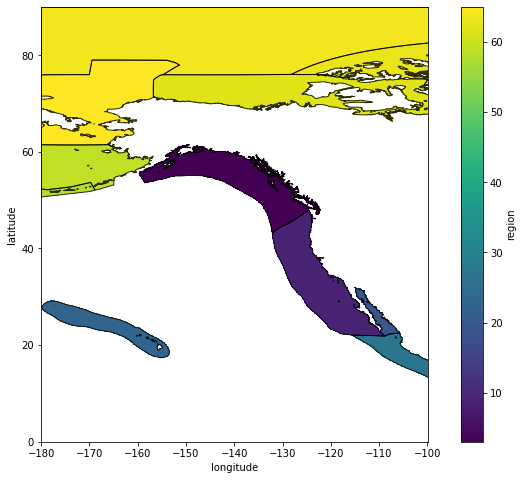

In [9]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
mask.plot(ax=ax)
lmes.plot(ax=ax, alpha=0.8, facecolor="none", lw=1)

In [10]:
def get_lme_id(lme_name):
    LME_REGION = [
        (i, name) for i, name in enumerate(lmes["LME_NAME"]) if name == lme_name
    ]
    print("Mask covers LME {} at index {}".format(LME_REGION[0][1], LME_REGION[0][0]))
    return LME_REGION[0][0]

In [11]:
cal_ID = get_lme_id("California Current")
goa_ID = get_lme_id("Gulf of Alaska")

lat = mask.latitude.values
lon = mask.longitude.values

# [print(i,name) for i,name in enumerate(lmes["LME_NAME"])]

sel_mask = mask.where((mask == cal_ID) | (mask == goa_ID)).values

id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]

Mask covers LME California Current at index 9
Mask covers LME Gulf of Alaska at index 3


In [ ]:
%%time
def save_climatology(climatology,varname_to_file, varname, depth_index=None):
    
    if varname in ["thetao", "so"]:
        out_selected = climatology[varname].sel(latitude = slice(id_lat[0], id_lat[-1]), longitude = slice(id_lon[0], id_lon[-1])).isel(depth=depth_index).squeeze().compute().where(
    (mask == goa_ID) | (mask == cal_ID))
    else:
        out_selected = climatology[varname].sel(latitude = slice(id_lat[0], id_lat[-1]), longitude = slice(id_lon[0], id_lon[-1])).compute().where(
    (mask == goa_ID) | (mask == cal_ID))
    # Write to file
    coords = {
        "month": out_selected.month.values,
        "latitude": out_selected.latitude.values,
        "longitude": out_selected.longitude.values,
    }
    data_array = xr.DataArray(
        name=varname_to_file,
        data=out_selected,
        coords=coords,
        dims=["month", "latitude", "longitude"],
    )
    result_file = "../../oceanography/QIN/ncfiles/{}_climatology_glorys12v1.nc".format(varname_to_file)
    if not os.path.exists("ncfiles"):
        os.mkdir("ncfiles")
    if os.path.exists(result_file):
        os.remove(result_file)
    data_array.to_netcdf(result_file, "w")
                          
save_climatology(climatology,"sst", "thetao", 1)
save_climatology(climatology,"bottomT", "bottomT")
save_climatology(climatology,"sss", "so", 1)
save_climatology(climatology,"bottomS", "so", 50)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Restarting worker


In [ ]:
def get_WOA(varname):

    base_url = "https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o"

    files = ["{}{:02d}_01.nc".format(base_url, month) for month in range(1, 13)]

    print(files)
    d = xr.open_mfdataset(
        files,
        combine="by_coords",decode_times=False,
    )
    print(d)
    ds = d.assign_coords(lon=(((d.lon + 180) % 360) - 180)).sortby(
        "lon"
    )
    print(ds)


get_WOA("oxygen")

In [ ]:
plt.figure(figsize=(12, 8))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
cmap = plt.cm.get_cmap("RdBu_r")
out_sel.bottomT.isel(month=6).plot(ax=ax, cmap=cmap)
# lmes.plot(ax = ax, alpha = 0.8, facecolor = 'none')
land_10m = cfeature.NaturalEarthFeature("physical", "land", "10m")
ax.add_feature(land_10m, color="lightgrey", edgecolor=None, zorder=4)
ax.coastlines(resolution="10m", linewidth=1, color="black", alpha=1, zorder=5)

ldom = np.array([[45, 49], [-126, -123]])
ax.set_extent([ldom[1, 0], ldom[1, 1], ldom[0, 0], ldom[0, 1]], crs=ccrs.PlateCarree())
ax.set_xticks([*range(ldom[1, 0], ldom[1, 1] + 1, 1)], crs=ccrs.PlateCarree())
ax.set_yticks([*range(ldom[0, 0], ldom[0, 1] + 1, 1)], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.grid(True, zorder=1, alpha=0.5)
qbox = np.array(
    [[-124.5, -124, -124.3, -124.8, -124.5], [46.5, 46.5, 47.5, 47.5, 46.5]]
)
plt.plot(qbox[0, :], qbox[1, :], c="r", lw=2, zorder=5, alpha=0.7)

In [ ]:
# get bathymetry from ETOPO1
fname_topo = "../../oceanography/ETOPO1/ETOPO1_Ice_g_gmt4.grd"
ds_topo = xr.open_dataset(fname_topo)
ds_topo.close()
topo = ds_topo.z  # (10801, 21601)
topo2 = topo.sel(y=slice(ldom[0, 0], ldom[0, 1]), x=slice(ldom[1, 0], ldom[1, 1]))
x = topo2.x  # 21601
y = topo2.y  # 10801
X, Y = np.meshgrid(x, y)

In [ ]:
# monthly - climatology
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
# datax,datay=np.meshgrid(ds.lon.values,ds.lat.values)

lev = np.arange(6, 18, 0.5)
fig = plt.figure(figsize=(12, 12), dpi=150)
for i in range(12):

    ax = fig.add_subplot(3, 4, i + 1, projection=ccrs.PlateCarree())
    ax.coastlines(resolution="10m", linewidth=1.5, color="black", alpha=0.8, zorder=4)
    ax.set_extent(
        [ldom[1, 0], ldom[1, 1], ldom[0, 0], ldom[0, 1]], crs=ccrs.PlateCarree()
    )
    ax.set_xticks([*range(ldom[1, 0], ldom[1, 1] + 1, 1)], crs=ccrs.PlateCarree())
    ax.set_yticks([*range(ldom[0, 0], ldom[0, 1] + 1, 1)], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    plt.grid(True, zorder=0, alpha=0.5)
    # ax.set_aspect(1.5)
    plt.contour(
        X,
        Y,
        topo2,
        [-5000, -2000, -1000, -500, -200, -100, -50],
        colors="k",
        linewidths=0.5,
        linestyles="solid",
        zorder=3,
        alpha=0.8,
    )
    # print("Mean for month {} = {}".format(months[i],isel(month = i).mean()))
    print(climatology.thetao.isel(month=i, depth=0).squeeze())
    plt.contourf(
        climatology.longitude,
        climatology.latitude,
        climatology.thetao.isel(month=i, depth=0).squeeze(),
        levels=lev,
        cmap="RdBu_r",
        zorder=2,
        alpha=0.9,
        extend="both",
    )
    plt.colorbar(
        fraction=0.03,
        orientation="horizontal",
        ticks=[*range(int(lev[0]), int(lev[-1]) + 1, 2)],
    )
    plt.plot(qbox[0, :], qbox[1, :], c="r", lw=2, zorder=5, alpha=0.7)
    plt.title(months[i])

# plt.colorbar(fraction=0.06, pad=0.04)
plt.tight_layout(h_pad=1)

plt.savefig("./bottomT_monthly_clim_glorys12v1.png")
plt.show()

In [ ]:
def create_plots(ds2020, ds2050):  # only used for comparisons

    ds_diff = ds2050 - ds2020

    notnull = pd.notnull(ds2050["chl"][0])
    land_110m = cfeature.NaturalEarthFeature("physical", "land", "110m")
    proj = ccrs.PlateCarree()
    extent = [-20, 20, 50, 80]

    fig, axes = plt.subplots(
        nrows=4, ncols=3, figsize=(14, 16), subplot_kw={"projection": proj}
    )
    for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
        ds2020["chl"].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 0],
            cmap="Spectral_r",
            transform=ccrs.PlateCarree(),  # vmin=-30, vmax=30, cmap='Spectral_r',
            add_colorbar=True,
            extend="both",
        )
        axes[i, 0].set_extent(extent, crs=proj)
        axes[i, 0].add_feature(land_110m, color="lightgrey")
        axes[i, 0].add_feature(cfeature.COASTLINE, edgecolor="black")
        axes[i, 0].add_feature(cfeature.BORDERS, linestyle=":")

        ds2050["chl"].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 1],
            cmap="Spectral_r",
            transform=ccrs.PlateCarree(),  # vmin=-30, vmax=30, cmap='Spectral_r',
            add_colorbar=True,
            extend="both",
        )
        axes[i, 1].set_extent(extent, crs=proj)
        axes[i, 1].add_feature(land_110m, color="lightgrey")
        axes[i, 1].add_feature(cfeature.COASTLINE, edgecolor="black")
        axes[i, 1].add_feature(cfeature.BORDERS, linestyle=":")

        ds_diff["chl"].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 2],
            cmap="Spectral_r",
            transform=ccrs.PlateCarree(),  # vmin=-0.1, vmax=.1, cmap='RdBu_r',
            add_colorbar=True,
            extend="both",
        )
        axes[i, 2].set_extent(extent, crs=proj)
        axes[i, 2].add_feature(land_110m, color="lightgrey")
        axes[i, 2].add_feature(cfeature.COASTLINE, edgecolor="black")
        axes[i, 2].add_feature(cfeature.BORDERS, linestyle=":")

        axes[i, 0].set_ylabel(season)
        axes[i, 1].set_ylabel("")
        axes[i, 2].set_ylabel("")

    for ax in axes.flat:
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        ax.axes.axis("tight")
        ax.set_xlabel("")

    axes[0, 0].set_title("ds2020")
    axes[0, 1].set_title("ds2050")
    axes[0, 2].set_title("Difference")

    plt.tight_layout()

    fig.suptitle("Seasonal Chlorophyll", fontsize=16, y=1.02)
    plt.show()

In [ ]:
def season_mean(ds, calendar="standard"):
    # Make a DataArray of season/year groups
    year_season = xr.DataArray(
        ds.time.to_index().to_period(freq="Q-NOV").to_timestamp(how="E"),
        coords=[ds.time],
        name="year_season",
    )

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(
        get_dpm(ds.time.to_index(), calendar=calendar),
        coords=[ds.time],
        name="month_length",
    )
    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return np.log((ds * weights).groupby("time.season").sum(dim="time"))